<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>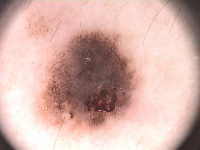</td><td>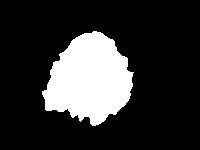</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=1953cbbe-dee4-4195-b3a0-5773bc999716
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 89.3MB/s]


In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

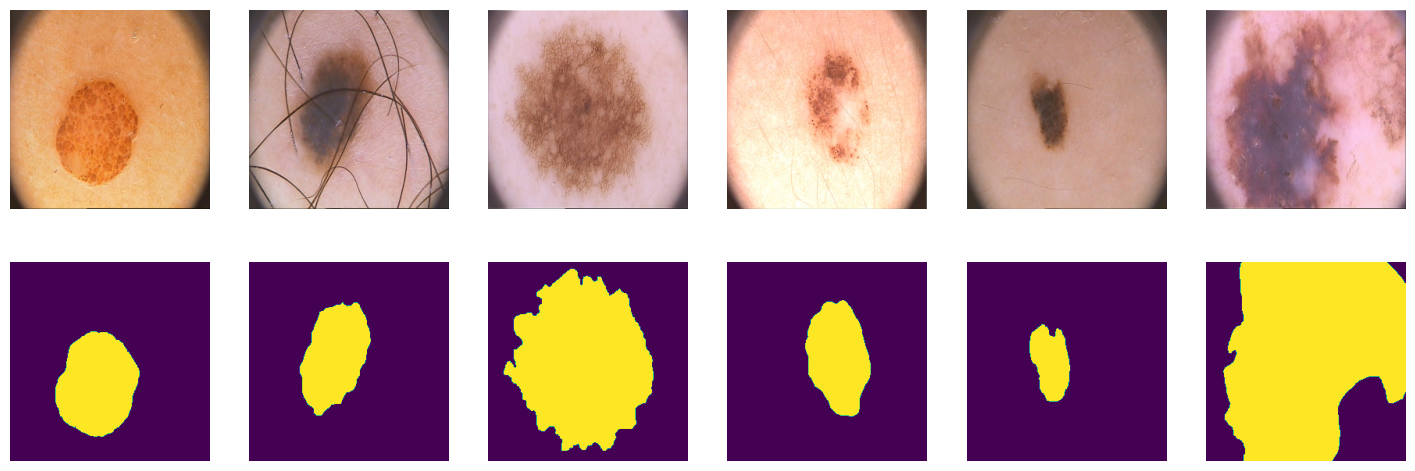

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [12]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 22.2 MB/s eta 0:00:00


In [13]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:** 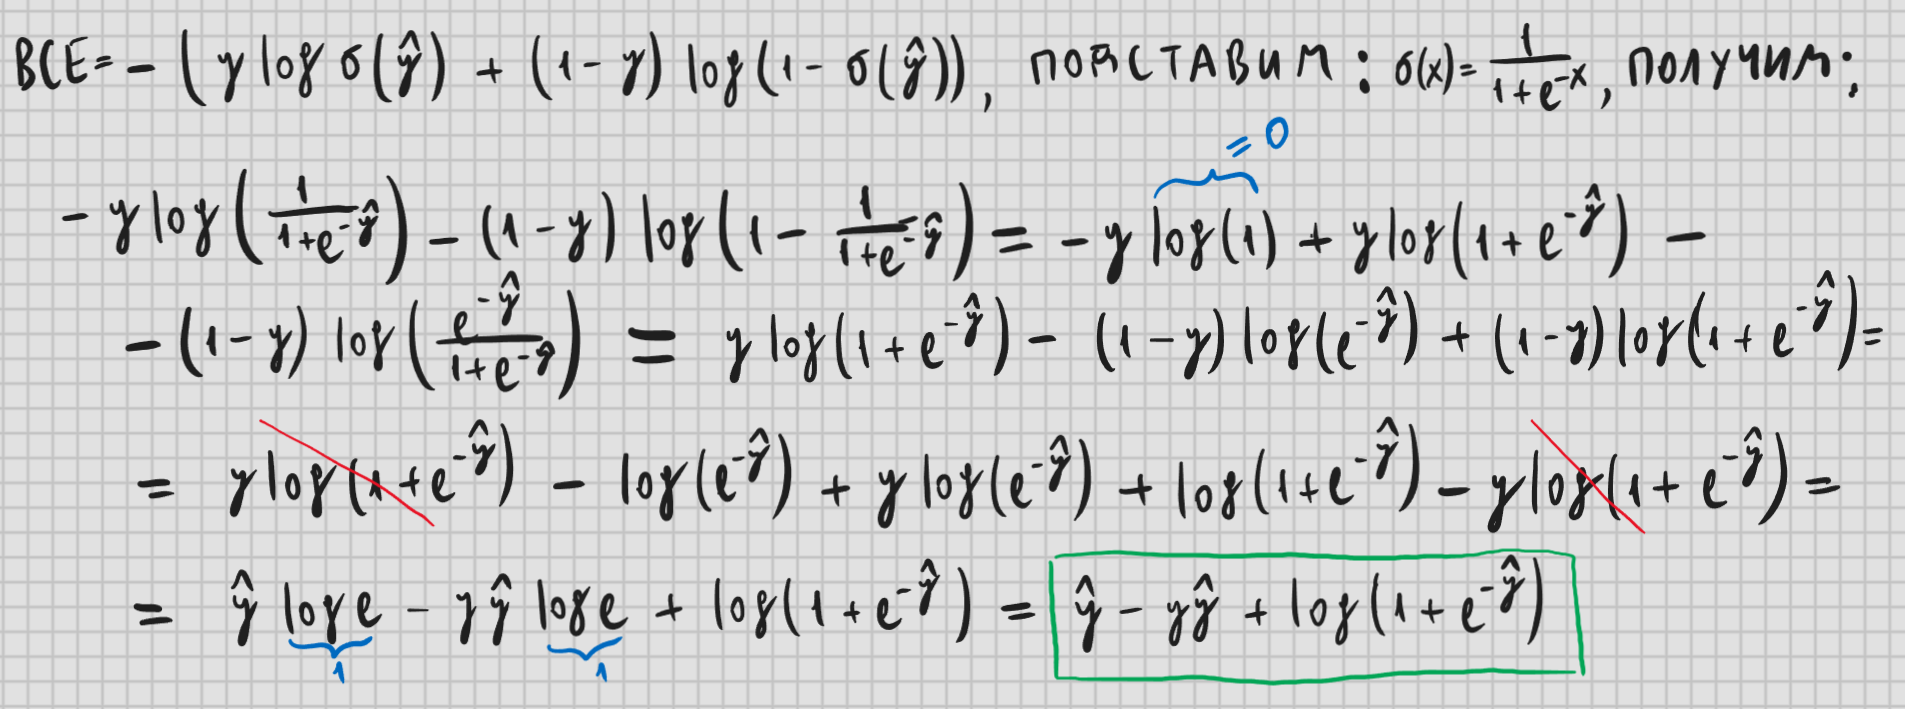

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [14]:
import torch.nn.functional as F
import torch.nn as nn

In [15]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [16]:
def bce_loss(y_pred, y_real):
  return torch.sum(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

def bce_true(y_pred, y_real):
  return -torch.sum(y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real)*torch.log(1 - torch.sigmoid(y_pred)))

Проверим корректность работы на простом примере

In [17]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 5.714421272277832
BCE loss честно посчитанный = 5.714421272277832
BCE loss from torch bce_torch = 5.714421272277832
BCE loss from torch with logits bce_torch = 5.714421272277832


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [18]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [19]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 10.854488372802734
BCE loss честно посчитанный = 10.854487419128418
BCE loss from torch bce_torch = 10.854488372802734
BCE loss from torch with logits bce_torch = 10.854488372802734


In [20]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [21]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 4.83MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 5.53MB/s]
Download completed


In [24]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

<ipython-input-24-cd9dbfff2c1b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
<ipython-input-

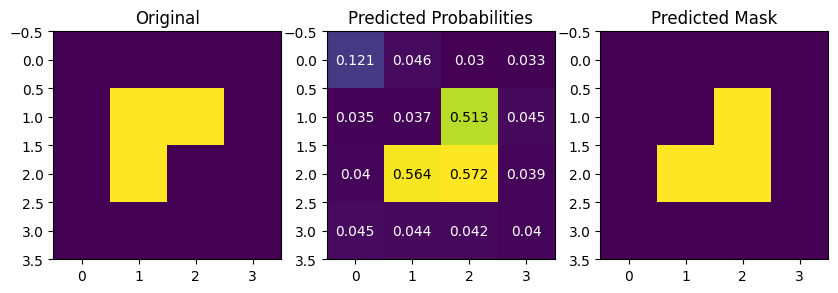

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [26]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

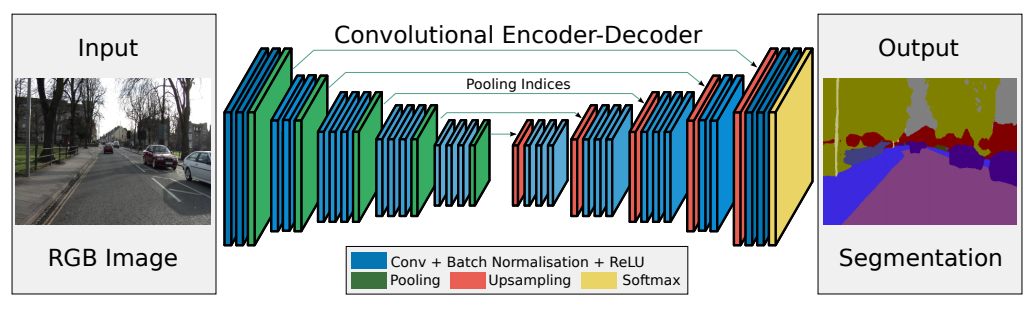

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [28]:
import torch
import torch.nn as nn

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder (VGG-16)
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [30]:
from torchmetrics.classification import JaccardIndex
from tqdm import tqdm

In [31]:
def train(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, device='cuda', threshold=0.5):
    model.to(device)

    # Для IoU метрики
    iou_metric = JaccardIndex(task="binary", threshold=threshold).to(device)

    # Списки для логов
    train_losses = []
    val_losses = []
    train_iou_scores = []
    val_iou_scores = []

    for epoch in range(num_epochs):
        # Тренировочная фаза
        model.train()
        running_loss = 0.0
        running_iou = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Считаем IoU
            predictions = (torch.sigmoid(outputs) > threshold).float()
            running_iou += iou_metric(predictions, labels).item()

        avg_train_loss = running_loss / len(train_loader)
        avg_train_iou = running_iou / len(train_loader)
        train_losses.append(avg_train_loss)
        train_iou_scores.append(avg_train_iou)

        # Валидационная фаза
        model.eval()
        val_loss = 0.0
        val_iou = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Считаем IoU
                predictions = (torch.sigmoid(outputs) > threshold).float()
                val_iou += iou_metric(predictions, labels).item()

        avg_val_loss = val_loss / len(valid_loader)
        avg_val_iou = val_iou / len(valid_loader)
        val_losses.append(avg_val_loss)
        val_iou_scores.append(avg_val_iou)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f} | Train IoU: {avg_train_iou:.4f} - "
              f"Validation Loss: {avg_val_loss:.4f} | Validation IoU: {avg_val_iou:.4f}")

    return model, train_losses, val_losses, train_iou_scores, val_iou_scores

In [32]:
# Функция для визуализации процесса обучения и валидации
def plot_metrics(train_losses, val_losses, train_iou, val_iou):
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # График для потерь (лоссов)
    axes[0].plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    axes[0].plot(epochs, val_losses, label='Validation Loss', color='orange', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Train and Validation Loss')
    axes[0].set_xticks(epochs)
    axes[0].legend()
    axes[0].grid(True)

    # График для IoU
    axes[1].plot(epochs, train_iou, label='Train IoU', color='green', marker='o')
    axes[1].plot(epochs, val_iou, label='Validation IoU', color='red', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('IoU')
    axes[1].set_title('Train and Validation IoU')
    axes[1].set_xticks(epochs)
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [33]:
segnet_bce = SegNet().to(device)
criterion_segnet_bce = nn.BCEWithLogitsLoss()
optimizer_segnet_bce = optim.Adam(segnet_bce.parameters(), lr=1e-4)
num_epochs = 20

segnet_bce, train_losses_segnet_bce, val_losses_segnet_bce, train_iou_segnet_bce, val_iou_segnet_bce = train(segnet_bce, train_dataloader, valid_dataloader, criterion_segnet_bce, optimizer_segnet_bce, num_epochs, 'cuda')

Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch [1/20] - Train Loss: 0.5927 | Train IoU: 0.4943 - Validation Loss: 0.6972 | Validation IoU: 0.3335


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


Epoch [2/20] - Train Loss: 0.4407 | Train IoU: 0.6913 - Validation Loss: 0.6910 | Validation IoU: 0.0094


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


Epoch [3/20] - Train Loss: 0.4162 | Train IoU: 0.7607 - Validation Loss: 0.6722 | Validation IoU: 0.0005


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


Epoch [4/20] - Train Loss: 0.4060 | Train IoU: 0.7944 - Validation Loss: 0.6523 | Validation IoU: 0.0000


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Epoch [5/20] - Train Loss: 0.3944 | Train IoU: 0.8095 - Validation Loss: 0.6445 | Validation IoU: 0.0000


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


Epoch [6/20] - Train Loss: 0.3938 | Train IoU: 0.8200 - Validation Loss: 0.6364 | Validation IoU: 0.0000


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Epoch [7/20] - Train Loss: 0.3896 | Train IoU: 0.8235 - Validation Loss: 0.6273 | Validation IoU: 0.0219


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


Epoch [8/20] - Train Loss: 0.3959 | Train IoU: 0.8198 - Validation Loss: 0.5898 | Validation IoU: 0.1834


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


Epoch [9/20] - Train Loss: 0.3862 | Train IoU: 0.8447 - Validation Loss: 0.4948 | Validation IoU: 0.5188


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Epoch [10/20] - Train Loss: 0.3945 | Train IoU: 0.8137 - Validation Loss: 0.4738 | Validation IoU: 0.6079


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]


Epoch [11/20] - Train Loss: 0.3760 | Train IoU: 0.8719 - Validation Loss: 0.4506 | Validation IoU: 0.6910


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]


Epoch [12/20] - Train Loss: 0.3732 | Train IoU: 0.8825 - Validation Loss: 0.4491 | Validation IoU: 0.7206


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Epoch [13/20] - Train Loss: 0.3727 | Train IoU: 0.8764 - Validation Loss: 0.4419 | Validation IoU: 0.7492


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Epoch [14/20] - Train Loss: 0.3779 | Train IoU: 0.8691 - Validation Loss: 0.4235 | Validation IoU: 0.7815


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


Epoch [15/20] - Train Loss: 0.3710 | Train IoU: 0.8969 - Validation Loss: 0.4218 | Validation IoU: 0.7792


Epoch 16/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Epoch [16/20] - Train Loss: 0.3691 | Train IoU: 0.8857 - Validation Loss: 0.4101 | Validation IoU: 0.7953


Epoch 17/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


Epoch [17/20] - Train Loss: 0.3689 | Train IoU: 0.8965 - Validation Loss: 0.4036 | Validation IoU: 0.8139


Epoch 18/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


Epoch [18/20] - Train Loss: 0.3727 | Train IoU: 0.8883 - Validation Loss: 0.4095 | Validation IoU: 0.7964


Epoch 19/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


Epoch [19/20] - Train Loss: 0.3644 | Train IoU: 0.9063 - Validation Loss: 0.4107 | Validation IoU: 0.7955


Epoch 20/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

Epoch [20/20] - Train Loss: 0.3664 | Train IoU: 0.8947 - Validation Loss: 0.4058 | Validation IoU: 0.8149


Plotting losses for BCE model:


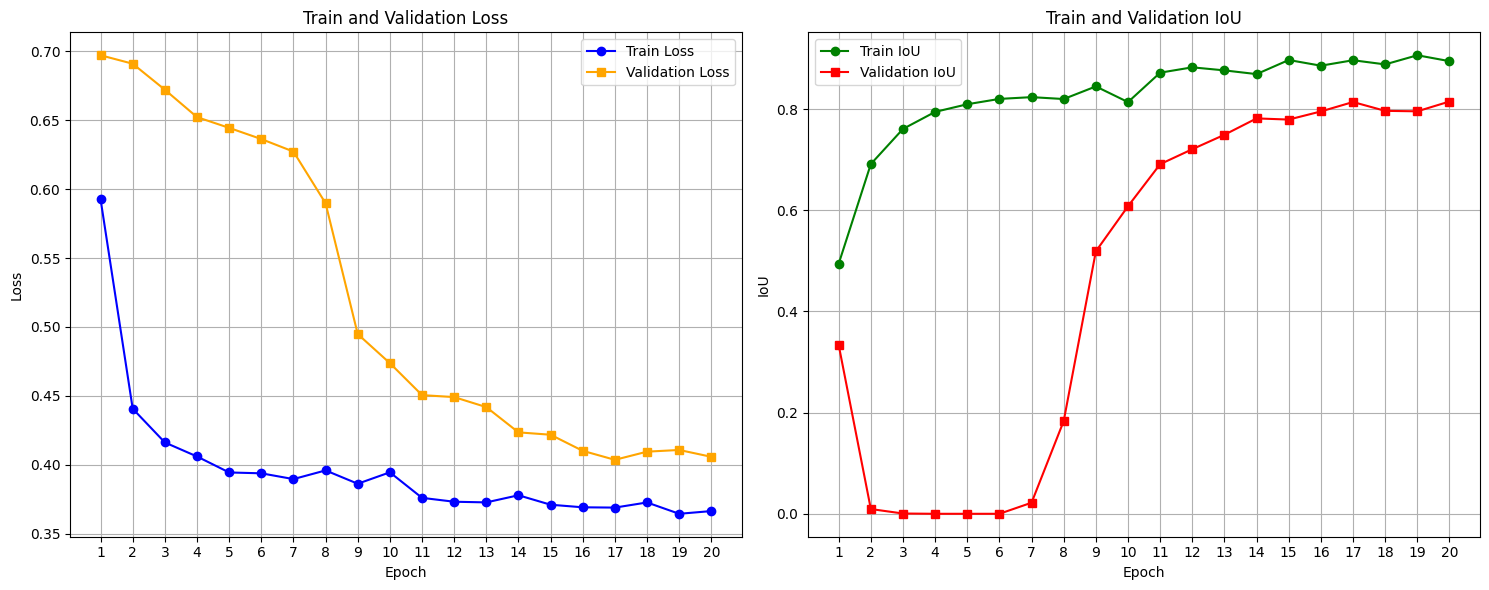

In [34]:
print("Plotting losses for BCE model:")
plot_metrics(train_losses_segnet_bce, val_losses_segnet_bce, train_iou_segnet_bce, val_iou_segnet_bce)

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [35]:
def test(model, test_loader, criterion, device='cuda', threshold=0.5):
    model.eval()
    model.to(device)

    iou_score = JaccardIndex(threshold=threshold, task="binary").to(device)
    total_loss = 0.0
    total_iou = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions = (torch.sigmoid(outputs) > threshold).float()
            batch_iou = iou_score(predictions, labels)
            total_iou += batch_iou.item()

    avg_loss = total_loss / len(test_loader)
    avg_iou = total_iou / len(test_loader)

    print(f"Test Loss: {avg_loss:.4f} - IoU: {avg_iou:.4f}")
    return avg_loss, avg_iou

In [36]:
# Получаем лосс и метрику iou для тестовых данных и модели segnet с лоссом BCE
test_loss_segnet_bce, test_iou_segnet_bce = test(segnet_bce, test_dataloader, criterion_segnet_bce, device)

Test Loss: 0.4038 - IoU: 0.8213


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [37]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    epsilon = 1e-8
    predict = (torch.sigmoid(logits) >= threshold).float()
    TP = torch.sum(predict * labels)
    FP = torch.sum(predict) - TP
    FN = torch.sum(labels) - TP
    score = (2 * TP + epsilon) / (2 * TP + FP + FN + epsilon)
    return score

Проверим на корректность функцию dice_score:

In [38]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [39]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [40]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    epsilon = 1e-8
    predict = torch.sigmoid(logits)
    TP = torch.sum(predict * labels)
    FP = torch.sum(predict) - TP
    FN = torch.sum(labels) - TP
    loss = 1 - (2 * TP + epsilon) / (2 * TP + FP + FN + epsilon)
    return loss

Проверка на корректность:

In [41]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=8aac75e5cc81212fadcd105ecb5c22ee35ce6f698855d013a2eaab1f46ff5697
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=3012023c28799794d036de4eb7e5363a0756fc63aeeb6921c5f2ceb0ed7f85c5
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [42]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [43]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [44]:
def focal_loss(logits, labels, eps=1e-8, gamma=2):
    probs = torch.sigmoid(logits)

    p_t = probs * labels + (1 - probs) * (1 - labels)
    p_t = torch.clamp(p_t, min=eps, max=1 - eps)  # Стабилизация

    L_BCE = nn.BCEWithLogitsLoss(reduction='none')(logits, labels)

    loss = torch.sum((1 - p_t) ** gamma * L_BCE)
    return loss

Проверка корректности функции:

In [45]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [46]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2.0)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [47]:
# Реализуем Tversky Loss
def tversky_loss(logits, labels, alpha=0.5, beta=0.5, epsilon=1e-6):
    predict = torch.sigmoid(logits)
    TP = torch.sum(predict * labels)
    FP = torch.sum(predict) - TP
    FN = torch.sum(labels) - TP
    loss = 1 - (TP + epsilon) / (TP + alpha * FN + beta * FP + epsilon)
    return loss

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



**Все модели обучаем на 20 эпохах с использованием Adam с lr=1e-4. Но каждая модель тренрируется на своём лоссе: focal, dice, tversky:**

In [49]:
segnet_dice = SegNet().to(device)
criterion_segnet_dice = dice_loss
optimizer_segnet_dice = optim.Adam(segnet_dice.parameters(), lr=1e-4)
num_epochs = 20

segnet_dice, train_losses_segnet_dice, val_losses_segnet_dice, train_iou_segnet_dice, val_iou_segnet_dice = train(segnet_dice, train_dataloader, valid_dataloader, criterion_segnet_dice, optimizer_segnet_dice, num_epochs, 'cuda')

Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


Epoch [1/20] - Train Loss: 0.5098 | Train IoU: 0.4963 - Validation Loss: 0.6033 | Validation IoU: 0.0000


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


Epoch [2/20] - Train Loss: 0.4234 | Train IoU: 0.6666 - Validation Loss: 0.6099 | Validation IoU: 0.0000


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


Epoch [3/20] - Train Loss: 0.4087 | Train IoU: 0.7144 - Validation Loss: 0.6280 | Validation IoU: 0.0000


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Epoch [4/20] - Train Loss: 0.4003 | Train IoU: 0.7466 - Validation Loss: 0.6341 | Validation IoU: 0.0000


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


Epoch [5/20] - Train Loss: 0.4062 | Train IoU: 0.7295 - Validation Loss: 0.6496 | Validation IoU: 0.0000


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


Epoch [6/20] - Train Loss: 0.3886 | Train IoU: 0.7988 - Validation Loss: 0.6402 | Validation IoU: 0.0196


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Epoch [7/20] - Train Loss: 0.3877 | Train IoU: 0.8179 - Validation Loss: 0.5938 | Validation IoU: 0.2479


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


Epoch [8/20] - Train Loss: 0.3834 | Train IoU: 0.8208 - Validation Loss: 0.5263 | Validation IoU: 0.4578


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


Epoch [9/20] - Train Loss: 0.3933 | Train IoU: 0.8030 - Validation Loss: 0.4563 | Validation IoU: 0.6616


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]


Epoch [10/20] - Train Loss: 0.3820 | Train IoU: 0.8419 - Validation Loss: 0.4309 | Validation IoU: 0.6923


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


Epoch [11/20] - Train Loss: 0.3803 | Train IoU: 0.8486 - Validation Loss: 0.4180 | Validation IoU: 0.7181


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


Epoch [12/20] - Train Loss: 0.3786 | Train IoU: 0.8574 - Validation Loss: 0.4141 | Validation IoU: 0.7177


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Epoch [13/20] - Train Loss: 0.3768 | Train IoU: 0.8698 - Validation Loss: 0.4069 | Validation IoU: 0.7628


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch [14/20] - Train Loss: 0.3817 | Train IoU: 0.8637 - Validation Loss: 0.4007 | Validation IoU: 0.7864


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Epoch [15/20] - Train Loss: 0.3732 | Train IoU: 0.8798 - Validation Loss: 0.3906 | Validation IoU: 0.7935


Epoch 16/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Epoch [16/20] - Train Loss: 0.3715 | Train IoU: 0.8927 - Validation Loss: 0.3896 | Validation IoU: 0.7843


Epoch 17/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Epoch [17/20] - Train Loss: 0.3713 | Train IoU: 0.9080 - Validation Loss: 0.3999 | Validation IoU: 0.7975


Epoch 18/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


Epoch [18/20] - Train Loss: 0.3714 | Train IoU: 0.8825 - Validation Loss: 0.3954 | Validation IoU: 0.8051


Epoch 19/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


Epoch [19/20] - Train Loss: 0.3723 | Train IoU: 0.8943 - Validation Loss: 0.3832 | Validation IoU: 0.7938


Epoch 20/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

Epoch [20/20] - Train Loss: 0.3749 | Train IoU: 0.8856 - Validation Loss: 0.3838 | Validation IoU: 0.8002


In [51]:
segnet_focal = SegNet().to(device)
criterion_segnet_focal = focal_loss
optimizer_segnet_focal = optim.Adam(segnet_focal.parameters(), lr=1e-4)
num_epochs = 20

segnet_focal, train_losses_segnet_focal, val_losses_segnet_focal, train_iou_segnet_focal, val_iou_segnet_focal = train(segnet_focal, train_dataloader, valid_dataloader, criterion_segnet_focal, optimizer_segnet_focal, num_epochs, 'cuda')

Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


Epoch [1/20] - Train Loss: 309002.0117 | Train IoU: 0.4944 - Validation Loss: 271275.6094 | Validation IoU: 0.0000


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Epoch [2/20] - Train Loss: 142588.8828 | Train IoU: 0.6873 - Validation Loss: 265725.4062 | Validation IoU: 0.0000


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Epoch [3/20] - Train Loss: 122751.7988 | Train IoU: 0.7421 - Validation Loss: 262088.2578 | Validation IoU: 0.0000


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Epoch [4/20] - Train Loss: 113688.7969 | Train IoU: 0.7849 - Validation Loss: 264430.7734 | Validation IoU: 0.0000


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]


Epoch [5/20] - Train Loss: 108937.7168 | Train IoU: 0.7963 - Validation Loss: 267340.6328 | Validation IoU: 0.0000


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


Epoch [6/20] - Train Loss: 108071.7363 | Train IoU: 0.7951 - Validation Loss: 257478.2578 | Validation IoU: 0.0000


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


Epoch [7/20] - Train Loss: 105843.5117 | Train IoU: 0.8032 - Validation Loss: 277591.6562 | Validation IoU: 0.0000


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


Epoch [8/20] - Train Loss: 99607.8438 | Train IoU: 0.8267 - Validation Loss: 254271.7500 | Validation IoU: 0.0457


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


Epoch [9/20] - Train Loss: 105276.0781 | Train IoU: 0.8024 - Validation Loss: 181082.8672 | Validation IoU: 0.4626


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


Epoch [10/20] - Train Loss: 92419.9277 | Train IoU: 0.8491 - Validation Loss: 151038.6719 | Validation IoU: 0.6597


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Epoch [11/20] - Train Loss: 86244.1641 | Train IoU: 0.8694 - Validation Loss: 155261.8594 | Validation IoU: 0.5838


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Epoch [12/20] - Train Loss: 88923.7344 | Train IoU: 0.8641 - Validation Loss: 131203.6250 | Validation IoU: 0.7029


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Epoch [13/20] - Train Loss: 84435.1074 | Train IoU: 0.8781 - Validation Loss: 121249.0000 | Validation IoU: 0.7575


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


Epoch [14/20] - Train Loss: 84067.1582 | Train IoU: 0.8836 - Validation Loss: 115946.0781 | Validation IoU: 0.7754


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


Epoch [15/20] - Train Loss: 82232.4609 | Train IoU: 0.8879 - Validation Loss: 113647.1953 | Validation IoU: 0.7784


Epoch 16/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


Epoch [16/20] - Train Loss: 80746.3574 | Train IoU: 0.8934 - Validation Loss: 108287.3945 | Validation IoU: 0.8036


Epoch 17/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Epoch [17/20] - Train Loss: 82084.4707 | Train IoU: 0.8844 - Validation Loss: 106800.5156 | Validation IoU: 0.7971


Epoch 18/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]


Epoch [18/20] - Train Loss: 80081.8398 | Train IoU: 0.8913 - Validation Loss: 108503.6562 | Validation IoU: 0.7953


Epoch 19/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


Epoch [19/20] - Train Loss: 78310.6758 | Train IoU: 0.8975 - Validation Loss: 106128.2617 | Validation IoU: 0.8093


Epoch 20/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

Epoch [20/20] - Train Loss: 84569.0605 | Train IoU: 0.8727 - Validation Loss: 104274.2500 | Validation IoU: 0.8131


In [52]:
segnet_tversky = SegNet().to(device)
criterion_segnet_tversky = tversky_loss
optimizer_segnet_tversky = optim.Adam(segnet_tversky.parameters(), lr=1e-4)
num_epochs = 20

segnet_tversky, train_losses_segnet_tversky, val_losses_segnet_tversky, train_iou_segnet_tversky, val_iou_segnet_tversky = train(segnet_tversky, train_dataloader, valid_dataloader, criterion_segnet_tversky, optimizer_segnet_tversky, num_epochs, 'cuda')

Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


Epoch [1/20] - Train Loss: 0.4966 | Train IoU: 0.4809 - Validation Loss: 0.6128 | Validation IoU: 0.0000


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]


Epoch [2/20] - Train Loss: 0.4216 | Train IoU: 0.6509 - Validation Loss: 0.6279 | Validation IoU: 0.0000


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]


Epoch [3/20] - Train Loss: 0.4001 | Train IoU: 0.7487 - Validation Loss: 0.6363 | Validation IoU: 0.0000


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Epoch [4/20] - Train Loss: 0.3944 | Train IoU: 0.7791 - Validation Loss: 0.6475 | Validation IoU: 0.0000


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Epoch [5/20] - Train Loss: 0.3955 | Train IoU: 0.7642 - Validation Loss: 0.6593 | Validation IoU: 0.0000


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


Epoch [6/20] - Train Loss: 0.3894 | Train IoU: 0.7837 - Validation Loss: 0.6662 | Validation IoU: 0.0000


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Epoch [7/20] - Train Loss: 0.3958 | Train IoU: 0.7929 - Validation Loss: 0.6682 | Validation IoU: 0.0000


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


Epoch [8/20] - Train Loss: 0.3931 | Train IoU: 0.7966 - Validation Loss: 0.6718 | Validation IoU: 0.0000


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


Epoch [9/20] - Train Loss: 0.3831 | Train IoU: 0.8289 - Validation Loss: 0.5742 | Validation IoU: 0.3361


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


Epoch [10/20] - Train Loss: 0.3843 | Train IoU: 0.8205 - Validation Loss: 0.4986 | Validation IoU: 0.6078


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


Epoch [11/20] - Train Loss: 0.3802 | Train IoU: 0.8533 - Validation Loss: 0.4602 | Validation IoU: 0.6967


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Epoch [12/20] - Train Loss: 0.3758 | Train IoU: 0.8776 - Validation Loss: 0.4268 | Validation IoU: 0.7339


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Epoch [13/20] - Train Loss: 0.3768 | Train IoU: 0.8590 - Validation Loss: 0.4309 | Validation IoU: 0.7844


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Epoch [14/20] - Train Loss: 0.3771 | Train IoU: 0.8809 - Validation Loss: 0.4073 | Validation IoU: 0.8042


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]


Epoch [15/20] - Train Loss: 0.3751 | Train IoU: 0.8708 - Validation Loss: 0.4017 | Validation IoU: 0.7853


Epoch 16/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


Epoch [16/20] - Train Loss: 0.3764 | Train IoU: 0.8713 - Validation Loss: 0.3945 | Validation IoU: 0.8019


Epoch 17/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


Epoch [17/20] - Train Loss: 0.3735 | Train IoU: 0.8901 - Validation Loss: 0.3915 | Validation IoU: 0.8082


Epoch 18/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Epoch [18/20] - Train Loss: 0.3816 | Train IoU: 0.8400 - Validation Loss: 0.3875 | Validation IoU: 0.8071


Epoch 19/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Epoch [19/20] - Train Loss: 0.3765 | Train IoU: 0.8751 - Validation Loss: 0.3797 | Validation IoU: 0.8064


Epoch 20/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

Epoch [20/20] - Train Loss: 0.3745 | Train IoU: 0.8740 - Validation Loss: 0.3758 | Validation IoU: 0.7783


Plotting losses for Tversky model:


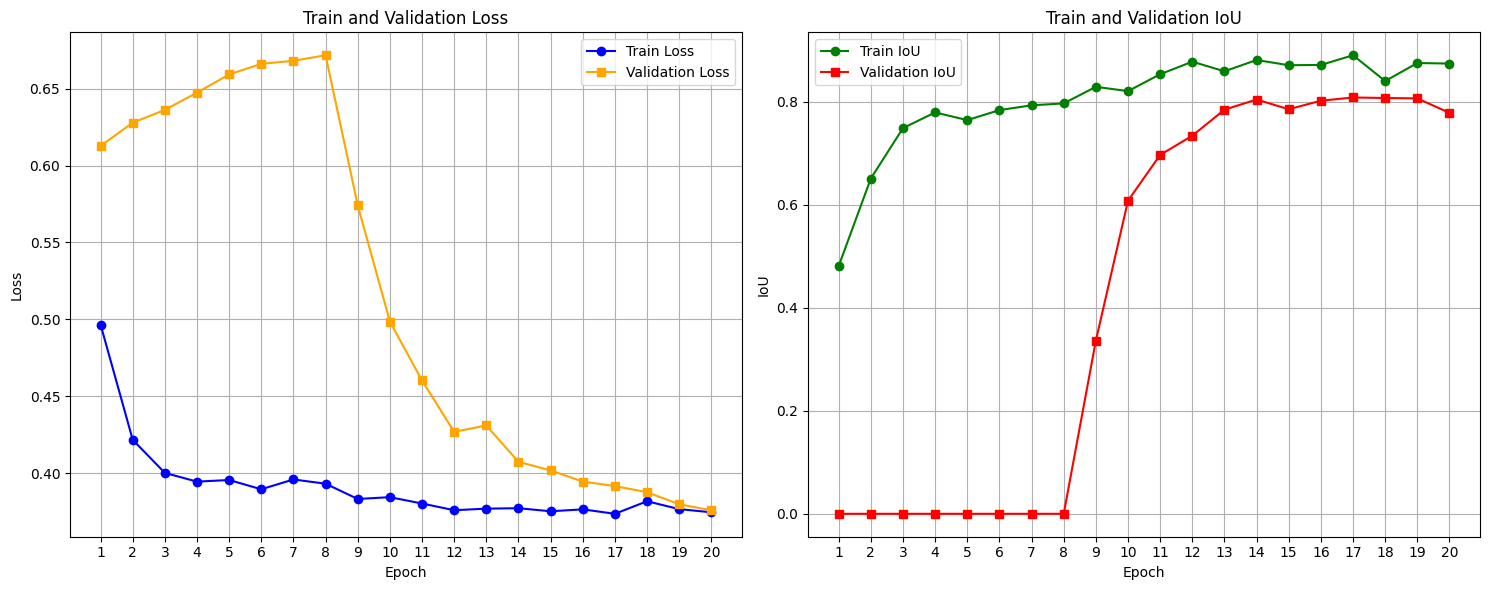

Plotting losses for Dice model:


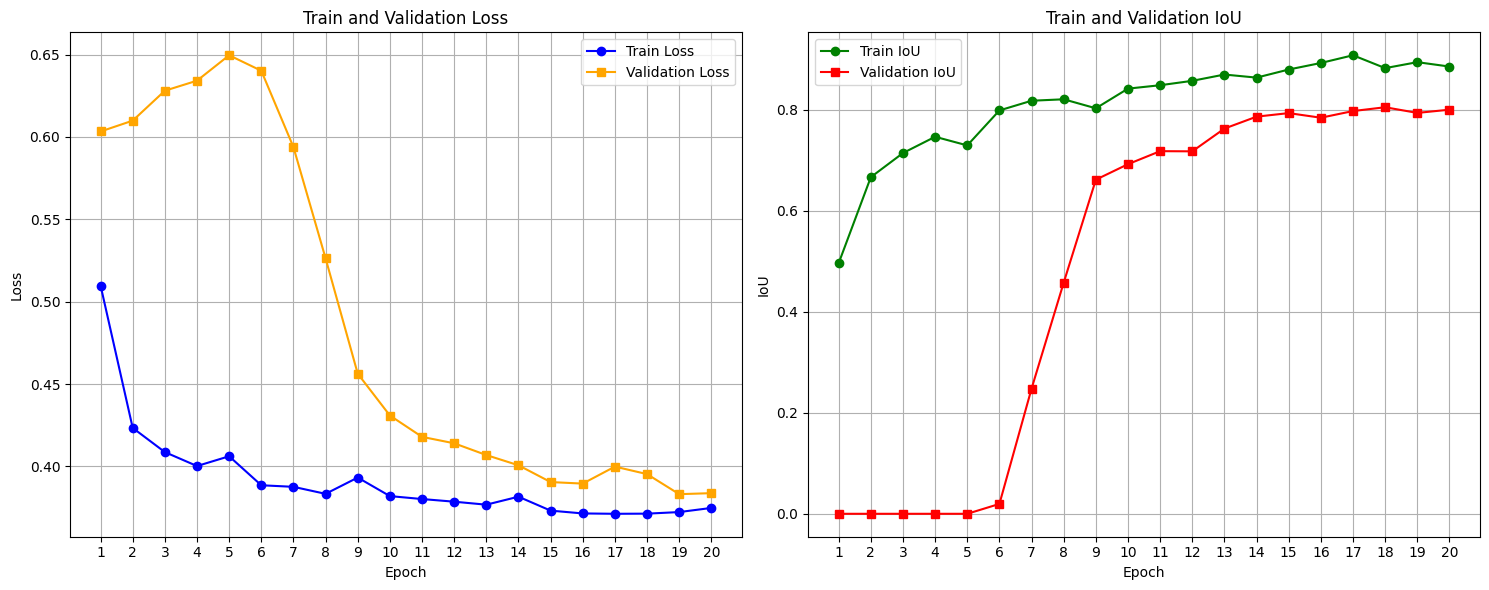

Plotting losses for Focal model:


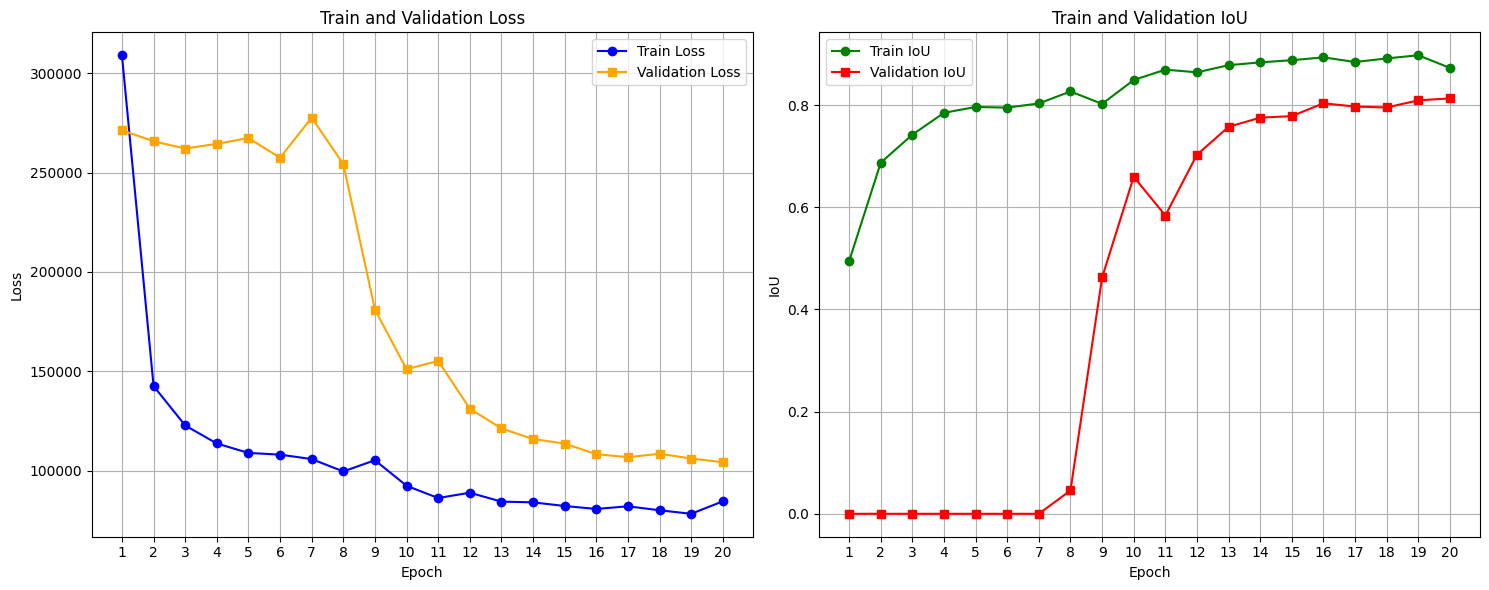

In [91]:
# Построение графиков для каждой модели
print("Plotting losses for Tversky model:")
plot_metrics(train_losses_segnet_tversky, val_losses_segnet_tversky, train_iou_segnet_tversky, val_iou_segnet_tversky)

print("Plotting losses for Dice model:")
plot_metrics(train_losses_segnet_dice, val_losses_segnet_dice, train_iou_segnet_dice, val_iou_segnet_dice)

print("Plotting losses for Focal model:")
plot_metrics(train_losses_segnet_focal, val_losses_segnet_focal, train_iou_segnet_focal, val_iou_segnet_focal)

In [92]:
# Тестируем модели и собираем результаты
results_segnet = []
results_segnet.append(('Dice', *test(segnet_dice, test_dataloader, criterion_segnet_dice, device)))
results_segnet.append(('Focal', *test(segnet_focal, test_dataloader, criterion_segnet_focal, device)))
results_segnet.append(('Tversky', *test(segnet_tversky, test_dataloader, criterion_segnet_tversky, device)))

Test Loss: 0.3994 - IoU: 0.7675
Test Loss: 111395.4883 - IoU: 0.7925
Test Loss: 0.3938 - IoU: 0.7512


In [93]:
# Форматированный вывод
print(f"{'Model':<10}{'Loss':<10}{'IoU':<10}")
print("-" * 30)
for model_name, loss, iou in results_segnet:
    print(f"{model_name:<10}{loss:<10.4f}{iou:<10.4f}")

Model     Loss      IoU       
------------------------------
Dice      0.3994    0.7675    
Focal     111395.48830.7925    
Tversky   0.3938    0.7512    


In [56]:
# Сохраняем модели
torch.save(segnet_bce, 'segnet_bce.pth')
torch.save(segnet_dice, 'segnet_dice.pth')
torch.save(segnet_focal, 'segnet_focal.pth')
torch.save(segnet_tversky, 'segnet_tversky.pth')

**1) При каком лоссе модель сходится быстрее?**  
Модель сходится быстрее при использовании Tversky Loss, поскольку значение этой функции потерь (0.3938) является самым низким, что указывает на более стабильное и быстрое снижение лосса в процессе обучения. Это говорит о том, что модель быстрее достигает состояния, близкого к оптимальному, по сравнению с другими лоссами.

**2) При каком лоссе модель выдает наилучшую метрику?**  
Наилучшая метрика IoU достигается при использовании Focal Loss, где значение составляет 0.7925. Несмотря на высокий номинальный результат функции потерь, Focal Loss лучше справляется с задачей сегментации, обеспечивая чуть более высокое качество перекрытия, чем Dice или Tversky Loss. Однако разница в метриках между лоссами минимальна, что говорит о близкой эффективности подходов в контексте данной задачи.

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

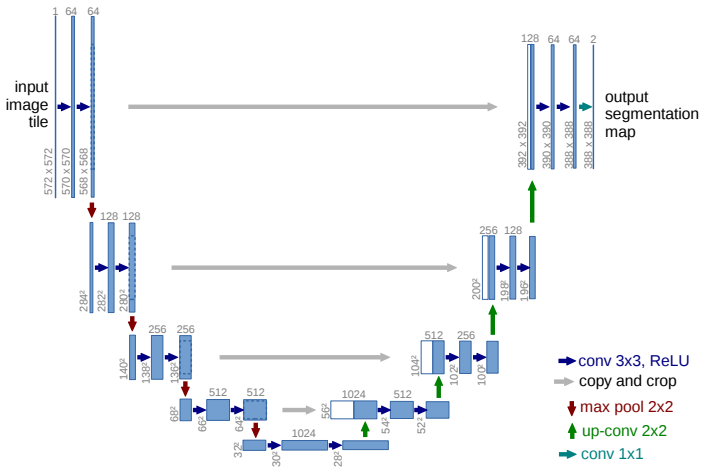

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [77]:
class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1):
        super(UNet, self).__init__()

        # Contracting path (Encoder)
        self.encoder1 = self._block(in_channels, 64)
        self.encoder2 = self._block(64, 128)
        self.encoder3 = self._block(128, 256)
        self.encoder4 = self._block(256, 512)

        # Bottleneck
        self.bottleneck = self._block(512, 1024)

        # Expanding path (Decoder)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self._block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self._block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self._block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self._block(128, 64)

        # Output layer
        self.conv_out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self._downsample(enc1))
        enc3 = self.encoder3(self._downsample(enc2))
        enc4 = self.encoder4(self._downsample(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self._downsample(enc4))

        # Decoder
        dec4 = self.decoder4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))
        dec3 = self.decoder3(torch.cat((self.upconv3(dec4), enc3), dim=1))
        dec2 = self.decoder2(torch.cat((self.upconv2(dec3), enc2), dim=1))
        dec1 = self.decoder1(torch.cat((self.upconv1(dec2), enc1), dim=1))

        return self.conv_out(dec1)

    def _block(self, in_channels, out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)
      )

    def _downsample(self, x):
        return nn.MaxPool2d(kernel_size=2, stride=2)(x)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



**Все модели обучаем на 20 эпохах с использованием Adam с lr=1e-4. Но каждая модель тренрируется на своём лоссе: focal, dice, bce:**

In [82]:
unet_bce = UNet().to(device)
criterion_unet_bce = nn.BCEWithLogitsLoss()
optimizer_unet_bce = optim.Adam(unet_bce.parameters(), lr=1e-4)
num_epochs = 20

unet_bce, train_losses_unet_bce, val_losses_unet_bce, train_iou_unet_bce, val_iou_unet_bce = train(unet_bce, train_dataloader, valid_dataloader, criterion_unet_bce, optimizer_unet_bce, num_epochs, 'cuda')

Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch [1/20] - Train Loss: 0.6642 | Train IoU: 0.3946 - Validation Loss: 0.7058 | Validation IoU: 0.3335


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch [2/20] - Train Loss: 0.5012 | Train IoU: 0.6065 - Validation Loss: 0.7012 | Validation IoU: 0.3335


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch [3/20] - Train Loss: 0.4176 | Train IoU: 0.7125 - Validation Loss: 0.6846 | Validation IoU: 0.5239


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch [4/20] - Train Loss: 0.3799 | Train IoU: 0.7310 - Validation Loss: 0.6490 | Validation IoU: 0.3005


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [5/20] - Train Loss: 0.3396 | Train IoU: 0.7871 - Validation Loss: 0.6067 | Validation IoU: 0.2766


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [6/20] - Train Loss: 0.3060 | Train IoU: 0.8275 - Validation Loss: 0.5724 | Validation IoU: 0.1720


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [7/20] - Train Loss: 0.2951 | Train IoU: 0.8229 - Validation Loss: 0.5291 | Validation IoU: 0.2757


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch [8/20] - Train Loss: 0.2775 | Train IoU: 0.8368 - Validation Loss: 0.4728 | Validation IoU: 0.3868


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [9/20] - Train Loss: 0.2727 | Train IoU: 0.8423 - Validation Loss: 0.4317 | Validation IoU: 0.4432


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [10/20] - Train Loss: 0.2763 | Train IoU: 0.8357 - Validation Loss: 0.3565 | Validation IoU: 0.6657


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [11/20] - Train Loss: 0.2514 | Train IoU: 0.8673 - Validation Loss: 0.3365 | Validation IoU: 0.7430


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Epoch [12/20] - Train Loss: 0.2523 | Train IoU: 0.8600 - Validation Loss: 0.3375 | Validation IoU: 0.7431


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [13/20] - Train Loss: 0.2473 | Train IoU: 0.8672 - Validation Loss: 0.2918 | Validation IoU: 0.7968


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [14/20] - Train Loss: 0.2415 | Train IoU: 0.8745 - Validation Loss: 0.2670 | Validation IoU: 0.8173


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [15/20] - Train Loss: 0.2247 | Train IoU: 0.9009 - Validation Loss: 0.2616 | Validation IoU: 0.8200


Epoch 16/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch [16/20] - Train Loss: 0.2312 | Train IoU: 0.8764 - Validation Loss: 0.2570 | Validation IoU: 0.8404


Epoch 17/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [17/20] - Train Loss: 0.2258 | Train IoU: 0.8982 - Validation Loss: 0.2554 | Validation IoU: 0.8345


Epoch 18/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [18/20] - Train Loss: 0.2179 | Train IoU: 0.9025 - Validation Loss: 0.2450 | Validation IoU: 0.8365


Epoch 19/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [19/20] - Train Loss: 0.2127 | Train IoU: 0.9069 - Validation Loss: 0.2669 | Validation IoU: 0.8250


Epoch 20/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

Epoch [20/20] - Train Loss: 0.2110 | Train IoU: 0.9043 - Validation Loss: 0.2518 | Validation IoU: 0.8432


In [83]:
unet_dice = UNet().to(device)
criterion_unet_dice = dice_loss
optimizer_unet_dice = optim.Adam(unet_dice.parameters(), lr=1e-4)
num_epochs = 20

unet_dice, train_losses_unet_dice, val_losses_unet_dice, train_iou_unet_dice, val_iou_unet_dice = train(unet_dice, train_dataloader, valid_dataloader, criterion_unet_dice, optimizer_unet_dice, num_epochs, 'cuda')

Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch [1/20] - Train Loss: 0.5162 | Train IoU: 0.4877 - Validation Loss: 0.6080 | Validation IoU: 0.0000


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch [2/20] - Train Loss: 0.4178 | Train IoU: 0.5892 - Validation Loss: 0.6105 | Validation IoU: 0.0000


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch [3/20] - Train Loss: 0.3636 | Train IoU: 0.6270 - Validation Loss: 0.6116 | Validation IoU: 0.0000


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Epoch [4/20] - Train Loss: 0.3306 | Train IoU: 0.6512 - Validation Loss: 0.6109 | Validation IoU: 0.0063


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch [5/20] - Train Loss: 0.3028 | Train IoU: 0.6857 - Validation Loss: 0.6079 | Validation IoU: 0.1211


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch [6/20] - Train Loss: 0.2836 | Train IoU: 0.7326 - Validation Loss: 0.6221 | Validation IoU: 0.0086


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [7/20] - Train Loss: 0.2812 | Train IoU: 0.7648 - Validation Loss: 0.5897 | Validation IoU: 0.1328


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [8/20] - Train Loss: 0.2581 | Train IoU: 0.8182 - Validation Loss: 0.3508 | Validation IoU: 0.5977


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [9/20] - Train Loss: 0.2580 | Train IoU: 0.8082 - Validation Loss: 0.2927 | Validation IoU: 0.6980


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [10/20] - Train Loss: 0.2413 | Train IoU: 0.8209 - Validation Loss: 0.2695 | Validation IoU: 0.7347


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [11/20] - Train Loss: 0.2542 | Train IoU: 0.8093 - Validation Loss: 0.2585 | Validation IoU: 0.7320


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [12/20] - Train Loss: 0.2276 | Train IoU: 0.8551 - Validation Loss: 0.2565 | Validation IoU: 0.7386


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [13/20] - Train Loss: 0.2357 | Train IoU: 0.8403 - Validation Loss: 0.2437 | Validation IoU: 0.7757


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [14/20] - Train Loss: 0.2231 | Train IoU: 0.8408 - Validation Loss: 0.2345 | Validation IoU: 0.7942


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [15/20] - Train Loss: 0.2266 | Train IoU: 0.8560 - Validation Loss: 0.2302 | Validation IoU: 0.8011


Epoch 16/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [16/20] - Train Loss: 0.2207 | Train IoU: 0.8547 - Validation Loss: 0.2195 | Validation IoU: 0.8282


Epoch 17/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [17/20] - Train Loss: 0.2211 | Train IoU: 0.8423 - Validation Loss: 0.2365 | Validation IoU: 0.7968


Epoch 18/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [18/20] - Train Loss: 0.2078 | Train IoU: 0.8862 - Validation Loss: 0.2107 | Validation IoU: 0.8422


Epoch 19/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


Epoch [19/20] - Train Loss: 0.2069 | Train IoU: 0.8876 - Validation Loss: 0.2121 | Validation IoU: 0.8446


Epoch 20/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

Epoch [20/20] - Train Loss: 0.2120 | Train IoU: 0.8775 - Validation Loss: 0.2144 | Validation IoU: 0.8472


In [84]:
unet_focal = UNet().to(device)
criterion_unet_focal = focal_loss
optimizer_unet_focal = optim.Adam(unet_focal.parameters(), lr=1e-4)
num_epochs = 20

unet_focal, train_losses_unet_focal, val_losses_unet_focal, train_iou_unet_focal, val_iou_unet_focal = train(unet_focal, train_dataloader, valid_dataloader, criterion_unet_focal, optimizer_unet_focal, num_epochs, 'cuda')

Epoch 1/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Epoch [1/20] - Train Loss: 266779.1875 | Train IoU: 0.4535 - Validation Loss: 282649.1094 | Validation IoU: 0.0004


Epoch 2/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Epoch [2/20] - Train Loss: 168698.3047 | Train IoU: 0.6567 - Validation Loss: 287621.7500 | Validation IoU: 0.3334


Epoch 3/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch [3/20] - Train Loss: 134299.0742 | Train IoU: 0.7267 - Validation Loss: 285820.0625 | Validation IoU: 0.2975


Epoch 4/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Epoch [4/20] - Train Loss: 111948.4746 | Train IoU: 0.7714 - Validation Loss: 271235.9062 | Validation IoU: 0.3146


Epoch 5/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


Epoch [5/20] - Train Loss: 101135.0723 | Train IoU: 0.7940 - Validation Loss: 245835.9219 | Validation IoU: 0.3627


Epoch 6/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Epoch [6/20] - Train Loss: 90717.4062 | Train IoU: 0.8290 - Validation Loss: 216912.5859 | Validation IoU: 0.4042


Epoch 7/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch [7/20] - Train Loss: 89249.4590 | Train IoU: 0.8072 - Validation Loss: 188429.1562 | Validation IoU: 0.4723


Epoch 8/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [8/20] - Train Loss: 88501.5762 | Train IoU: 0.8112 - Validation Loss: 158654.3672 | Validation IoU: 0.5738


Epoch 9/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch [9/20] - Train Loss: 75564.9121 | Train IoU: 0.8432 - Validation Loss: 141787.9219 | Validation IoU: 0.6574


Epoch 10/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [10/20] - Train Loss: 68928.3164 | Train IoU: 0.8625 - Validation Loss: 143483.3828 | Validation IoU: 0.6575


Epoch 11/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [11/20] - Train Loss: 66390.4131 | Train IoU: 0.8627 - Validation Loss: 120086.6875 | Validation IoU: 0.7348


Epoch 12/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Epoch [12/20] - Train Loss: 72553.3418 | Train IoU: 0.8471 - Validation Loss: 89567.6406 | Validation IoU: 0.8070


Epoch 13/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [13/20] - Train Loss: 63692.6201 | Train IoU: 0.8670 - Validation Loss: 88923.8203 | Validation IoU: 0.8084


Epoch 14/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [14/20] - Train Loss: 62404.7041 | Train IoU: 0.8718 - Validation Loss: 164635.6250 | Validation IoU: 0.7372


Epoch 15/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [15/20] - Train Loss: 59857.5273 | Train IoU: 0.8727 - Validation Loss: 91575.6602 | Validation IoU: 0.8057


Epoch 16/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [16/20] - Train Loss: 56973.6660 | Train IoU: 0.8782 - Validation Loss: 77860.6758 | Validation IoU: 0.8319


Epoch 17/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Epoch [17/20] - Train Loss: 69146.3174 | Train IoU: 0.8471 - Validation Loss: 81298.5781 | Validation IoU: 0.8135


Epoch 18/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch [18/20] - Train Loss: 52660.2236 | Train IoU: 0.8908 - Validation Loss: 83250.8867 | Validation IoU: 0.8302


Epoch 19/20 - Validation: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch [19/20] - Train Loss: 54873.0762 | Train IoU: 0.8798 - Validation Loss: 151437.8633 | Validation IoU: 0.7735


Epoch 20/20 - Validation: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

Epoch [20/20] - Train Loss: 56141.0693 | Train IoU: 0.8787 - Validation Loss: 152004.5469 | Validation IoU: 0.7915


Plotting losses for Dice model:


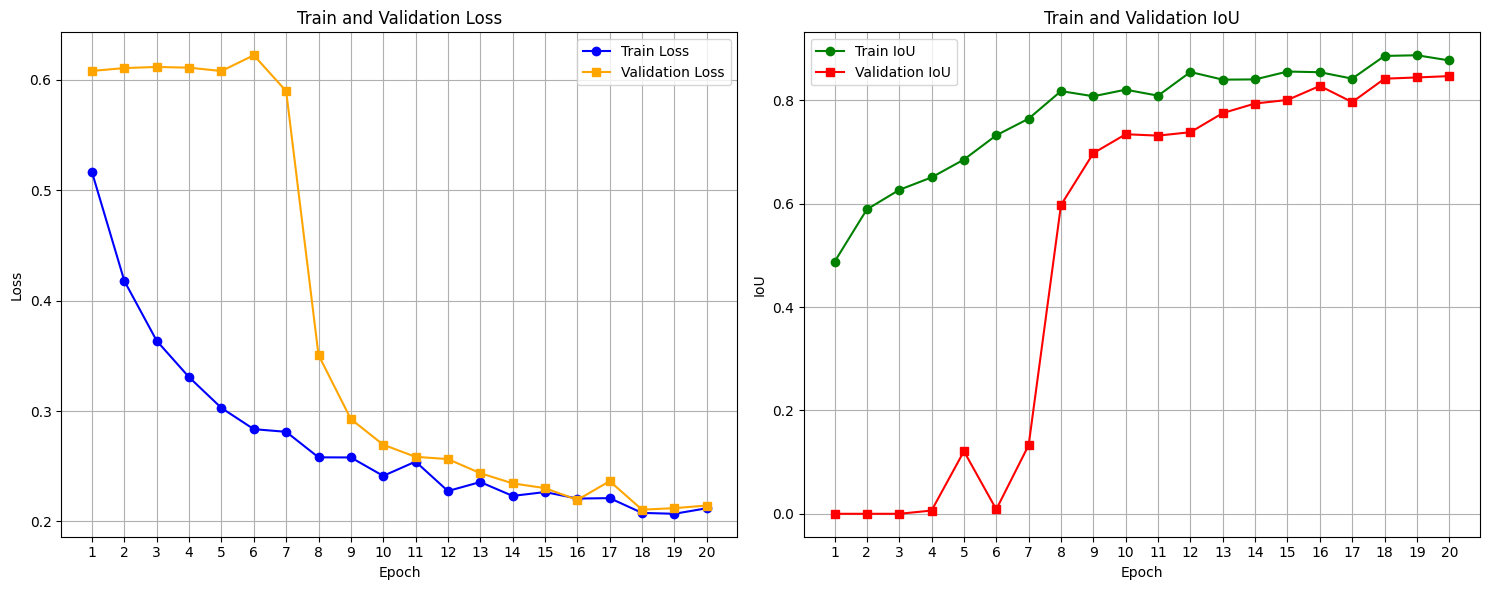

Plotting losses for Focal model:


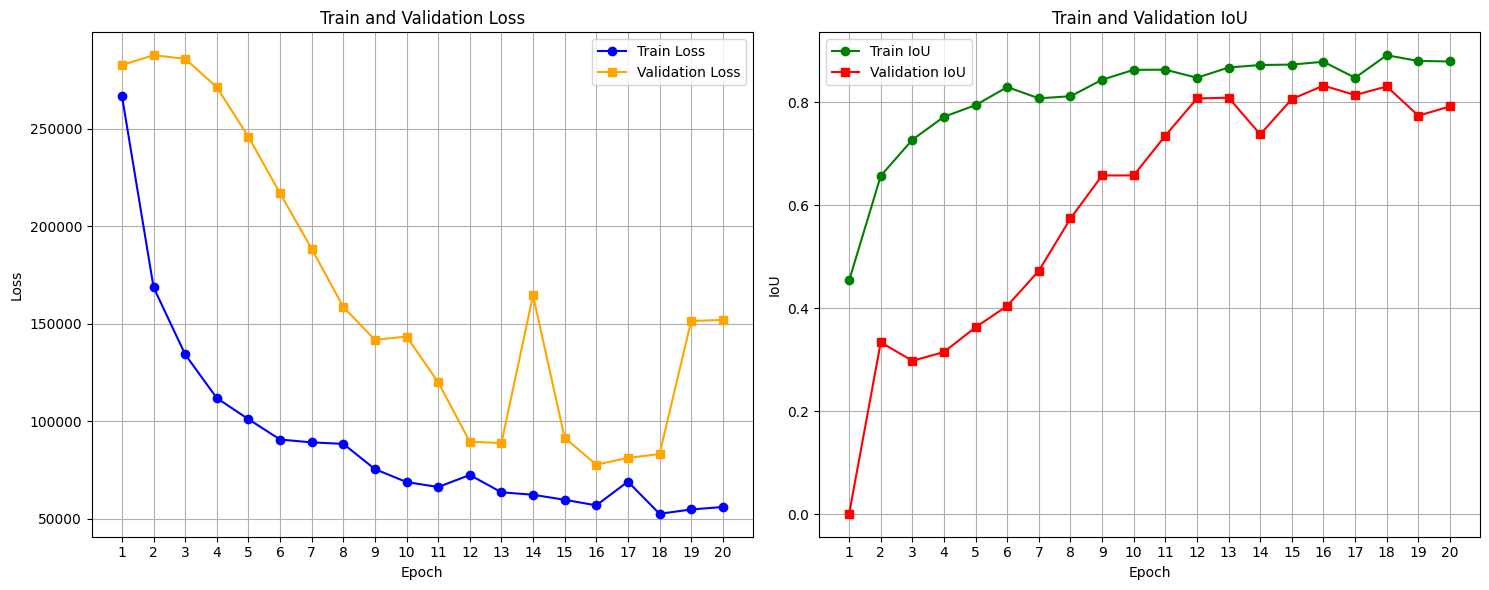

Plotting losses for BCE model:


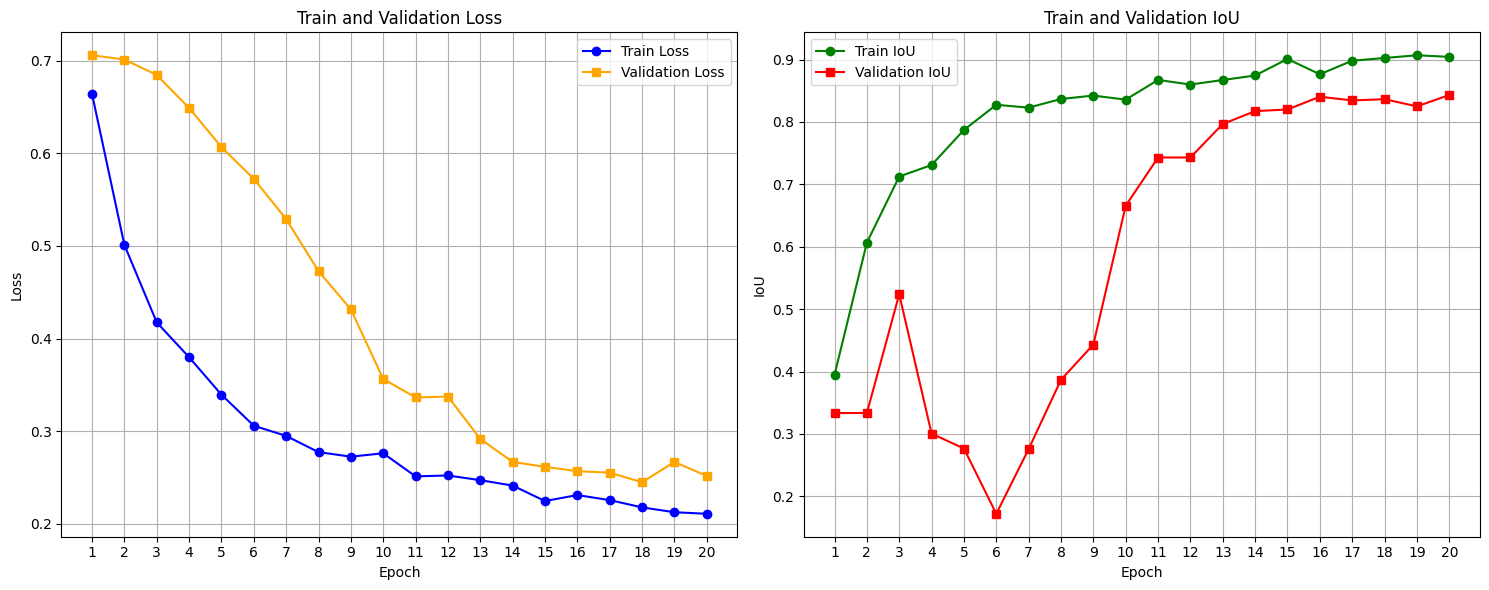

In [88]:
# Строим графики для всех моделей
print("Plotting losses for Dice model:")
plot_metrics(train_losses_unet_dice, val_losses_unet_dice, train_iou_unet_dice, val_iou_unet_dice)

print("Plotting losses for Focal model:")
plot_metrics(train_losses_unet_focal, val_losses_unet_focal, train_iou_unet_focal, val_iou_unet_focal)

print("Plotting losses for BCE model:")
plot_metrics(train_losses_unet_bce, val_losses_unet_bce, train_iou_unet_bce, val_iou_unet_bce)

In [89]:
# Тестируем модели и собираем результаты
results_unet = []
results_unet.append(('Dice', *test(unet_dice, test_dataloader, criterion_unet_dice, device)))
results_unet.append(('Focal', *test(unet_focal, test_dataloader, criterion_unet_focal, device)))
results_unet.append(('BCE', *test(unet_bce, test_dataloader, criterion_unet_bce, device)))

Test Loss: 0.2232 - IoU: 0.8476
Test Loss: 91952.7734 - IoU: 0.8018
Test Loss: 0.2685 - IoU: 0.8374


In [90]:
# Форматированный вывод
print(f"{'Model':<10}{'Loss':<10}{'IoU':<10}")
print("-" * 30)
for model_name, loss, iou in results_unet:
    print(f"{model_name:<10}{loss:<10.4f}{iou:<10.4f}")

Model     Loss      IoU       
------------------------------
Dice      0.2232    0.8476    
Focal     91952.77340.8018    
BCE       0.2685    0.8374    


**Какая модель дает лучшие значения по метрике?**

UNet на BCE Loss показывает лучшее значение IoU (0.8476) по сравнению с SegNet (0.8213). Это подтверждает, что UNet более эффективно сегментирует объекты, особенно за счет архитектуры с skip connections, позволяющей лучше восстанавливать мелкие детали. SegNet уступает по точности, так как его архитектура менее адаптивна для сложных деталей на границах объектов.

**Какая модель дает лучшие значения по лоссам?**

Наименьшее значение лосса также достигается UNet на BCE Loss (0.2232), что значительно ниже, чем у SegNet (0.4038). Это свидетельствует о том, что UNet минимизирует ошибку предсказания более эффективно, особенно на BCE Loss. Для задач, где важна минимизация лосса, UNet оказывается более предпочтительным.

**Какая модель обучается быстрее?**

UNet обучается быстрее, особенно при использовании BCE Loss. Низкий лосс (0.2232) указывает на то, что модель быстрее достигает оптимального состояния. SegNet, даже при использовании BCE Loss, демонстрирует более высокое значение лосса (0.4038), что говорит о необходимости большего количества эпох для достижения схожих результатов.

# **Теперь построим графики для вузального сравнения работы unet и segnet:**

In [94]:
# Функция для визуального сравнения моделей segnet и unet на разных лоссах
def segnet_vs_unet(loss_segnet, loss_unet, iou_segnet, iou_unet, title_loss, title_iou):
  fig, axs = plt.subplots(1, 2, figsize=(12, 5))
  epochs = list(range(1, 21))  # Эпохи обучения

  # Лоссы
  axs[0].plot(epochs, loss_segnet, label='SegNet', color='blue')
  axs[0].plot(epochs, loss_unet, label='UNet', color='orange')
  axs[0].set_title(title_loss)
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  axs[0].legend()
  axs[0].grid(True)

  # IoU
  axs[1].plot(epochs, iou_segnet, label='SegNet', color='blue')
  axs[1].plot(epochs, iou_unet, label='UNet', color='orange')
  axs[1].set_title(title_iou)
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('IoU')
  axs[1].legend()
  axs[1].grid(True)

  plt.tight_layout()
  plt.show()

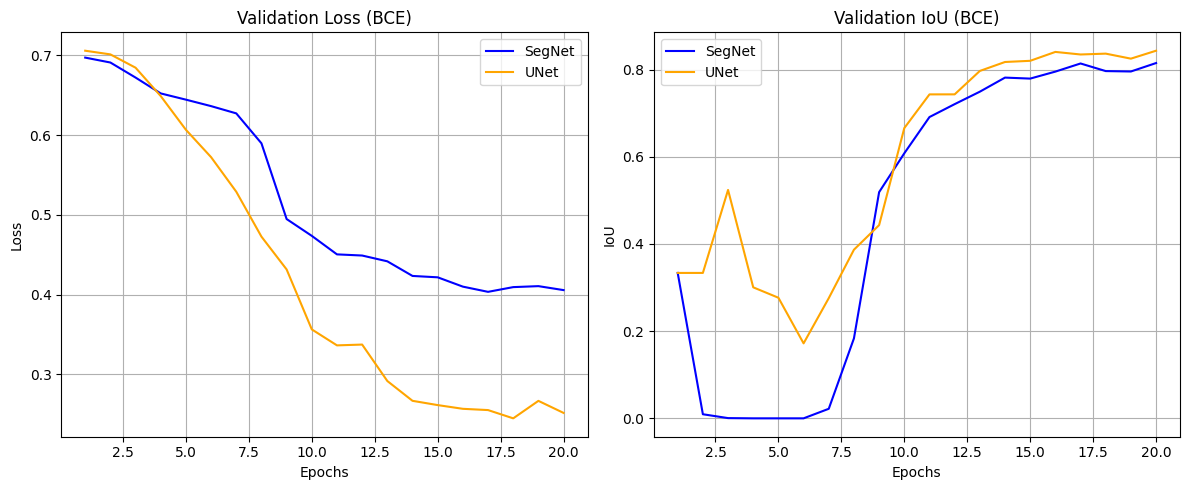

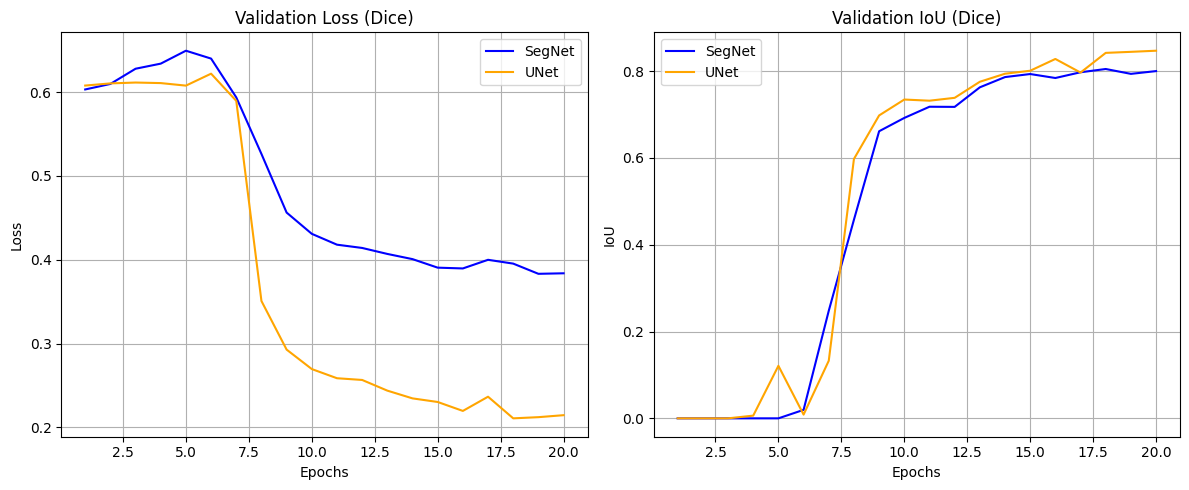

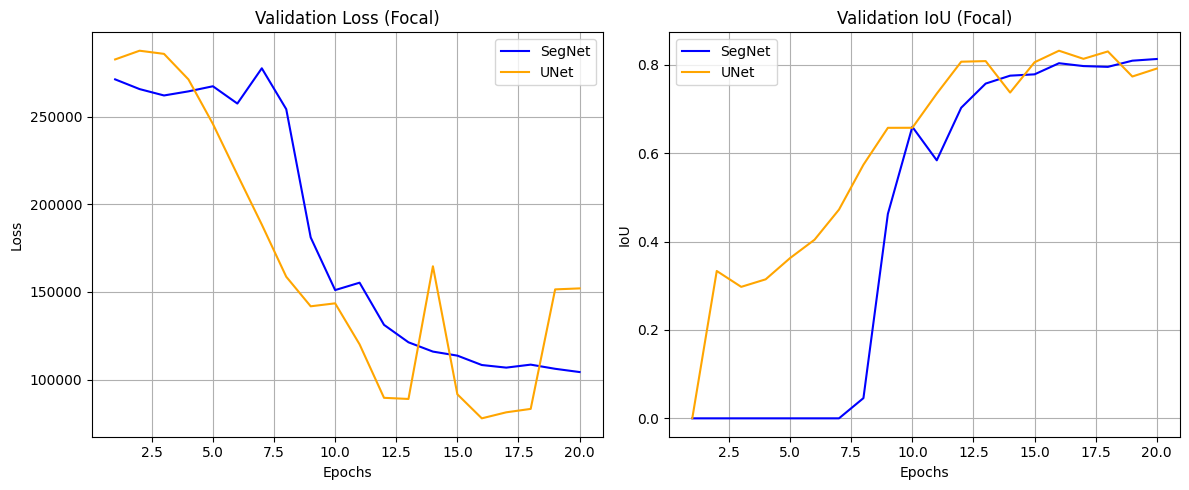

In [95]:
# Построение графиков для BCE
segnet_vs_unet(
    val_losses_segnet_bce, val_losses_unet_bce,
    val_iou_segnet_bce, val_iou_unet_bce,
    "Validation Loss (BCE)", "Validation IoU (BCE)"
)

# Построение графиков для Dice
segnet_vs_unet(
    val_losses_segnet_dice, val_losses_unet_dice,
    val_iou_segnet_dice, val_iou_unet_dice,
    "Validation Loss (Dice)", "Validation IoU (Dice)"
)

# Построение графиков для Focal
segnet_vs_unet(
    val_losses_segnet_focal, val_losses_unet_focal,
    val_iou_segnet_focal, val_iou_unet_focal,
    "Validation Loss (Focal)", "Validation IoU (Focal)"
)

**Анализ графиков:**

На всех графиках видно, что модель **UNet** значительно превосходит **SegNet** как по значению лосса, так и по метрике IoU. Например, при использовании **BCE Loss** UNet достигает существенно более низкого значения лосса и высоких показателей IoU, что указывает на более эффективное обучение и лучшую способность сегментировать объекты. SegNet показывает более высокие значения лосса и хуже справляется с восстановлением мелких деталей на объектах, что отражается и в более низких значениях IoU.

При использовании **Dice Loss** ситуация аналогична: хотя SegNet в начале обучения показывает некоторые улучшения, UNet быстро догоняет и стабильно показывает лучшие результаты по обоим метрикам. Это говорит о том, что UNet лучше адаптируется и быстрее находит оптимальное решение.

На графиках с **Focal Loss** видно, что UNet также превосходит SegNet, особенно в плане стабильности и улучшения метрики IoU в процессе обучения. Хотя для Focal Loss оба подхода показывают большее колебание лосса, UNet сохраняет преимущества по стабильности и точности сегментации.

В общем, **UNet** показывает лучшие результаты по всем меткам и функциям потерь, что делает её предпочтительнее для задач сегментации, требующих как минимизации ошибки, так и высокой точности.